In [1]:
# import netgen.gui
import ngsolve as ngs
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw
from ttictoc import tic, toc
from ngsolve.krylovspace import CGSolver

mesh = ngs.Mesh('whatever.vol')
mesh.Curve(2)
# mesh.Refine()

In [2]:
%run J.ipynb

using 3d mesh with ne= 72204  elements and nv= 12535  points
Solving...
Number of iterations = 503/1000 | Residual = 9.792831543321432e-06
2999.999999999987
Solving...
Number of iterations = 442/1000 | Residual = 9.899156656591516e-06
3000.0020577247274


In [3]:
from bhdata import BHCurves
fun_dw  = BHCurves(3)
fun_w   = fun_dw.Integrate()
fun_ddw = fun_dw.Differentiate()

mu0 = 1.256636e-6
nu0 = 1/mu0

linear = "coil|ambient|default"
nonlinear = "r_steel|l_steel|mid_steel"

lin = 0

BH data from TEAM 20 problem
returning energy


In [4]:
Q = ngs.VectorL2(mesh, order = deg-1)
V = ngs.H1(mesh, order = deg)
# V = ngs.H1(mesh, order = deg, dirichlet = "ambient_face")

X = Q*V
(p,u), (q,v) = X.TnT()

# Nonlinear:

maxit = int(1e7)

tol2 = 1e-8
regb = 1e-12

B_psi = ngs.GridFunction(X)

B = B_psi.components[0]
psi = B_psi.components[1]

normB = ngs.sqrt(B*B + regb)

if lin == 1: cf_energy = mesh.MaterialCF({linear: nu0/2*B*B, nonlinear: nu0/2*B*B}, default = nu0/2*B*B).Compile()
cf_energy = mesh.MaterialCF({linear: nu0/2*B*B, nonlinear: fun_w(normB)}, default = nu0/2*B*B).Compile()

def fun_W():
    with ngs.TaskManager(): res = ngs.Integrate(cf_energy - Hs*B, mesh)
    return res

ir = ngs.IntegrationRule(ngs.fem.ET.TET, order = 2*deg)

if lin == 1: cf_rhs = mesh.MaterialCF({linear: nu0, nonlinear: nu0}, default = nu0).Compile()
else: cf_rhs = mesh.MaterialCF({linear: nu0, nonlinear: fun_dw(normB)/normB}, default = nu0).Compile()

rhs = ngs.LinearForm(X)
rhs += ngs.SymbolicLFI(cf_rhs*B*q -ngs.grad(psi)*q -Hs*q +B*ngs.grad(v), intrule = ir)
# rhs = ngs.LinearForm((cf_rhs*B*q -ngs.grad(psi)*q -Hs*q +B*ngs.grad(v))*ngs.dx)

def fun_dW():
    with ngs.TaskManager(): rhs.Assemble()
    return rhs

Id = ngs.CF((1,0,0,
             0,1,0,
             0,0,1), dims=(3,3))

BBt = ngs.CF((B[0]*B[0], B[0]*B[1], B[0]*B[2],
              B[1]*B[0], B[1]*B[1], B[1]*B[2],
              B[2]*B[0], B[2]*B[1], B[2]*B[2]), dims = (3,3))

fun1 = fun_dw(normB)/normB
fun2 = (fun_ddw(normB) - fun_dw(normB)/normB)/(normB*normB)

if lin == 1: cf_iter = mesh.MaterialCF({linear: nu0*Id, nonlinear: nu0*Id}, default = nu0*Id).Compile()
else: cf_iter = mesh.MaterialCF({linear: nu0*Id, nonlinear: fun1*Id + fun2*BBt}, default = nu0*Id).Compile()

K_iter = ngs.BilinearForm(X, condense = True)
K_iter += ngs.SymbolicBFI(cf_iter*p*q - ngs.grad(u)*q + p*ngs.grad(v), intrule = ir)
# K_iter += (cf_iter*p*q - ngs.grad(u)*q + p*ngs.grad(v))*ngs.dx
C_iter = ngs.Preconditioner(K_iter, type = "local")

def fun_ddW():
    with ngs.TaskManager(): K_iter.Assemble()
    return K_iter


In [94]:
du = ngs.GridFunction(X)
uo = ngs.GridFunction(X)

size_du0 = du.components[0].vec.FV().NumPy().size
size_du1 = du.components[1].vec.FV().NumPy().size

import matplotlib.pyplot as plt
import numpy as np
rrow = np.arange(size_du1) + size_du0
rcol = np.arange(size_du1)
rdata = np.ones(rcol.size)

R  = ngs.la.SparseMatrixdouble.CreateFromCOO(rrow, rcol, rdata, size_du0+size_du1, size_du1)
RT = ngs.la.SparseMatrixdouble.CreateFromCOO(rcol, rrow, rdata, size_du1, size_du0+size_du1)

def compactify(A):
    A = ngs.la.SparseMatrixdouble.__matmul__(A,R)
    A = ngs.la.SparseMatrixdouble.__matmul__(RT,A)
    return A

In [113]:
print("Using 3D mesh with ne=", mesh.ne, "elements and nv=", mesh.nv, "points and " ,X.ndof, "DOFs.\n ")

with ngs.TaskManager(): B.Set(ngs.CF((0,0,0)))
with ngs.TaskManager(): psi.Set(ngs.CF((0)))

du = ngs.GridFunction(X)
uo = ngs.GridFunction(X)
wo = 1e12

for it in range(1,maxit+1):
    
    tic()
    # with ngs.TaskManager():
    #     K_iter.Assemble()
    #     rhs.Assemble()
    #     res = ngs.Integrate(cf_energy - Hs*ngs.curl(A), mesh)
    
    w  = fun_W()
    dw = fun_dW()
    da = fun_ddW()
    tm1 = toc()
    
    tic()
    with ngs.TaskManager():
        rhs_mod = (da.harmonic_extension_trans * rhs.vec).Evaluate()
        iterativeSolver = CGSolver(mat = compactify(da.mat), pre = C_iter.mat, tol  = 1e-4,  maxiter = maxit)
        # iterativeSolver = CGSolver(mat = da.mat, freedofs = X.FreeDofs(True), tol  = 1e-4,  maxiter = maxit)
        du.vec.data = iterativeSolver * (R*rhs_mod)
        du.vec.data = RT * du.vec

        du.vec.data += da.harmonic_extension * du.vec
        du.vec.data += da.inner_solve * rhs.vec

        # invS = da.mat.Inverse(freedofs = X.FreeDofs(coupling=True))
        # # invS = CGSolver(da.mat, freedofs = X.FreeDofs(coupling=True), tol  = 1e-4,  maxiter = maxit)
        # ext = ngs.IdentityMatrix() + da.harmonic_extension
        # extT = ngs.IdentityMatrix() + da.harmonic_extension_trans
        # invA =  ext @ invS @ extT + da.inner_solve
        # du.vec.data = invA * dw.vec

        # du.vec.data = da.mat.Inverse(X.FreeDofs()) * dw.vec
        # ngs.solvers.MinRes(mat=da.mat, pre=C_iter.mat, rhs=dw.vec, sol=du.vec, printrates=False, initialize=False, maxsteps=10000)
        # iterativeSolver = CGSolver(K_iter.mat, freedofs = X.FreeDofs(), atol = 1e-2,  maxiter = maxit, printrates = False)
        # iterativeSolver = CGSolver(K_iter.mat, pre = C_iter.mat, tol  = 1e-2,  maxiter = maxit)
        # du.vec.data = iterativeSolver * dw.vec
    
    if len(iterativeSolver.residuals) == maxit: print("... reached maxit!")
    # print(f"Number of iterations = {iterativeSolver.iterations}/{maxit} | Residual = {iterativeSolver.residuals[-1]}")
    tm2 = toc()

    nrm = ngs.InnerProduct(du.vec,dw.vec)
    
    if it == 1:
        nrm0 = nrm

    # wn = 1e12
    if abs(wo-w) < tol2:
    # if nrm/nrm0 < tol2:
        print("converged to desired tolerance")
        break
    # elif abs(wo-w) < tol2*1e-2:
    #     print("stopped early due to stagnation")
    #     break
    else:
        # linesearch
        uo.vec.data = B_psi.vec.data
        wo = w
        alpha = 1
        for init in range(1,21):
            B_psi.vec.data -= alpha*du.vec.data
            wn = fun_W()
            if wn < w - alpha*0.1*nrm:
                print("Iter: %2d | assem : %.2fs | CG took %.2fs with %4d iterations | alpha : %.2f | energy = %.10f | relres = %.2e |"  %(it,tm1,tm2,iterativeSolver.iterations,alpha,w,nrm/nrm0))
                break
            else:
                alpha = alpha/2
                B_psi.vec.data = uo.vec.data

Using 3D mesh with ne= 72204 elements and nv= 12535 points and  964043 DOFs.
 


AttributeError: 'ngsolve.la.DynamicVectorExpression' object has no attribute 'vec'

In [6]:
# Draw(BB, mesh)

In [7]:
scalars = mesh.MaterialCF({"coil": 1, "mid_steel": 2}, default = 0)
L2 = ngs.L2(mesh, order = 2)
scal = ngs.GridFunction(L2)
scal.Set(scalars)

vtk = ngs.VTKOutput(mesh, coefs = [B,ngs.curl(Hs),scal],names = ["B","J","scalars"], filename = "B2", order = 1)
vtk.Do()

'B2'

In [8]:
import pyvista as pv
pvmesh = pv.read("B2.vtu")
pvmesh.set_active_scalars("scalars")
pvmesh.set_active_vectors("B")
threshed = pvmesh.threshold([0.8,2.1])
# threshed.set_active_vectors("B")

p = pv.Plotter()
p.add_mesh(threshed, style = 'surface', color = "w", opacity = 0.01, label = None)

arrows = pvmesh.glyph(scale = "B", orient = True, tolerance = 0.01, factor = 0.01)
# arrows = pvmesh.glyph(scale = "B", orient = True, tolerance = 0.01, factor = 0.01)
p.add_mesh(arrows, color = "yellow")

pvmesh.set_active_vectors("J")
arrows2 = pvmesh.glyph(scale = "J", orient = True, tolerance = 0.001, factor = 1*1e-8)
p.add_mesh(arrows2, color = "black")

p.show(jupyter_backend = "html")
# p.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [9]:
print(ngs.Integrate(ngs.Norm(B),mesh))
print(fun_W())

0.00036099095438012365
-1.6074973371236418


<class 'ngsolve.la.SparseMatrixdouble'> <class 'ngsolve.la.TransposeMatrix'> <class 'ngsolve.la.SparseMatrixdouble'>


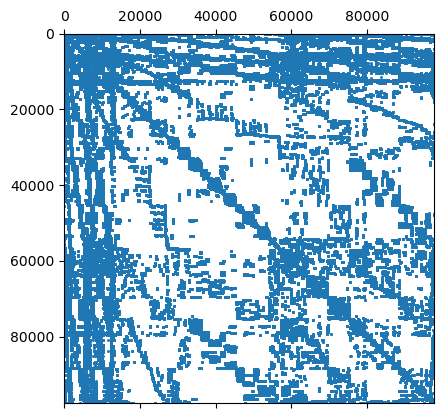

In [88]:
size_du0 = du.components[0].vec.FV().NumPy().size
size_du1 = du.components[1].vec.FV().NumPy().size

import matplotlib.pyplot as plt
import numpy as np
rrow = np.arange(size_du1) + size_du0
rcol = np.arange(size_du1)
rdata = np.ones(rcol.size)

R  = ngs.la.SparseMatrixdouble.CreateFromCOO(rrow, rcol, rdata, size_du0+size_du1, size_du1)
RT = ngs.la.SparseMatrixdouble.CreateFromCOO(rcol, rrow, rdata, size_du1, size_du0+size_du1)

def compactify(A):
    A = ngs.la.SparseMatrixdouble.__matmul__(A,R)
    A = ngs.la.SparseMatrixdouble.__matmul__(RT,A)
    return A

print(type(R),type(R.T), type(da.mat))





rrow

rows,cols,vals = RR.COO()
import scipy.sparse as sp
A = sp.csr_matrix((vals,(rows,cols)))

# print(A.shape)
plt.spy(A,markersize=1)
# print(A.nnz)
# rhs_mod.FV().NumPy().size

# A, X.FreeDofs()
# print(R.shape)

In [100]:
R * rhs_mod

In [12]:
help(ngs.IdentityMatrix())
# da.mat(freedofs=X.FreeDofs(coupling=True))

Help on IdentityMatrix in module ngsolve.la object:

class IdentityMatrix(BaseMatrix)
 |  Method resolution order:
 |      IdentityMatrix
 |      BaseMatrix
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: ngsolve.la.IdentityMatrix) -> None
 |      
 |      2. __init__(self: ngsolve.la.IdentityMatrix, size: int, complex: bool = False) -> None
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from BaseMatrix:
 |  
 |  AsVector(...)
 |      AsVector(self: ngsolve.la.BaseMatrix) -> ngsolve.la.BaseVector
 |      
 |      Interprets the matrix values as a vector
 |  
 |  CreateColVector(...)
 |      CreateColVector(self: ngsolve.la.BaseMatrix) -> ngsolve.la.BaseVector
 |  
 |  CreateDeviceMatrix(...)
 |      CreateDeviceMatrix(self: ngsolve.la.BaseMatrix) -> BaseMatrix
 |  